___

Last week, I played around with modeling simple sources with both Astropy and Sherpa. Sherpa is a modelling and fitting application developed for analysis of Chandra x-ray data. The recently released Sherpa for Python package offers a very useful comparison to existing Astropy methods. 

<b><font size="5">Astropy vs. Sherpa</font></b>

Here I've generated a mock source with random Poisson noise and fit it with a 2D Gaussian using both Astropy and Sherpa. Both use the Levenberg-Marquardt algorithm and least squares statistic and begin with the same intial guesses. 


In [5]:
% matplotlib inline
import numpy as np


import warnings
warnings.filterwarnings('ignore')
import sherpa.astro.ui as ui


import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('poster')
sns.set_style('white',{'grid':False})


In [2]:
%%%capture
%%writefile benchmarking.py

import numpy as np
import sherpa.astro.ui as ui
from astropy.modeling.models import Gaussian2D
from astropy import table
from astropy.nddata.utils import add_array


def gen_source_table(imshape, nsrc, stddev=3., mean_amp=10.):
    """
    Populate a source table with randomly placed 2D gaussians
    of constant width and variable amplitude. 
    
    Parameters
    ----------
    imshape : tuple
        Shape of the image.
    nsrc : int
        Number of sources:
    stddev : float, optional
        Standard deviation in pixels
    mean_amp : float, optional
        Mean amplitude 
   """
    
    # Buffer the edge of the image 
    buffer = np.ceil(stddev*10.)

    data = {}
    data['x_mean'] = np.around(np.random.rand(nsrc)*(imshape[1]-buffer))+buffer/2.
    data['y_mean'] = np.around(np.random.rand(nsrc)*(imshape[0]-buffer))+buffer/2.
    data['amplitude'] = np.abs(np.random.randn(nsrc)+mean_amp)
    data['x_stddev'] = np.ones(nsrc)*stddev
    data['y_stddev'] = np.ones(nsrc)*stddev
    data['theta'] = np.zeros(nsrc)
    
    return table.Table(data)




def make_gaussian_sources(image, source_table):
    """
    A simplified version of `~photutils.datasets.make_gaussian_sources`.
    Populates an image with 2D gaussian sources.
    
    Parameters
    ----------
    image_shape : tuple
        Shape of the image.
    source_table : astropy.table.table.Table
        Table of sources with model parameters.

   """
        
    y, x = np.indices(image.shape)

    for i, source in enumerate(source_table):
        model = Gaussian2D(amplitude=source['amplitude'], x_mean=source['x_mean'],
                           y_mean=source['y_mean'],
                           x_stddev=source['x_stddev'],
                           y_stddev=source['y_stddev'], theta=source['theta'])
       
        image += model(x, y)

    return image
    
    
def make_gaussian_sources_sherpa(image, source_table):
    """
    A simplified version of `~photutils.datasets.make_gaussian_sources`.
    Populates an image with 2D gaussian sources generaged with the Sherpa python package.
    
    Parameters
    ----------
    image_shape : tuple
        Shape of the image.
    source_table : astropy.table.table.Table
        Table of sources with model parameters.

   """
    
    ui.set_source(ui.gauss2d.g2)
    ui.freeze(g2)
    for i, source in enumerate(source_table):  
        g2.xpos=source['x_mean']+1
        g2.ypos=source['y_mean']+1
        g2.ellip = 0.
        g2.fwhm = sigma2fwhm(source['x_stddev'])
        g2.ampl=source['amplitude']
        g2.theta=0.
        mod = ui.get_model_image().y
        image += mod

    return image


def make_gaussian_sources_bb(image, source_table, width_factor=5):
    """
    A simplified version of `~photutils.datasets.make_gaussian_sources`.
    Populates an image with 2D gaussian sources.
    Uses a bounding box around each source to increase speed. 
    
    Parameters
    ----------
    image_shape : tuple
        Shape of the image.
    source_table : astropy.table.table.Table
        Table of sources with model parameters.
    width_factor: int
        Multiple of the standard deviation within which to bound the source.

   """

    for i, source in enumerate(source_table):
        dx,dy = np.ceil(width_factor*source['x_stddev']),np.ceil(width_factor*source['y_stddev'])
        subimg = (2*dx,2*dy)
        x,y = np.meshgrid(np.arange(-dx,dx)+source['x_mean'],np.arange(-dy,dy)+source['y_mean'])

        model = Gaussian2D(amplitude=source['amplitude'], x_mean=source['x_mean'],
                           y_mean=source['y_mean'],
                           x_stddev=source['x_stddev'],
                           y_stddev=source['y_stddev'], theta=source['theta'])
        
        image=add_array(image, model(x, y), (source['y_mean'],source['x_mean']))
        
    return image 



sigma2fwhm = lambda x: 2.*np.sqrt(2.*np.log(2.))*x

fwhm2sigma  = lambda x:x/(2.*np.sqrt(2.*np.log(2.)))

Astropy:
3 loops, best of 3: 30.1 ms per loop
7 iterations
4.31 ms per model evaluation


Sherpa:
3 loops, best of 3: 23.2 ms per loop
8 iterations
2.90 ms per model evaluation


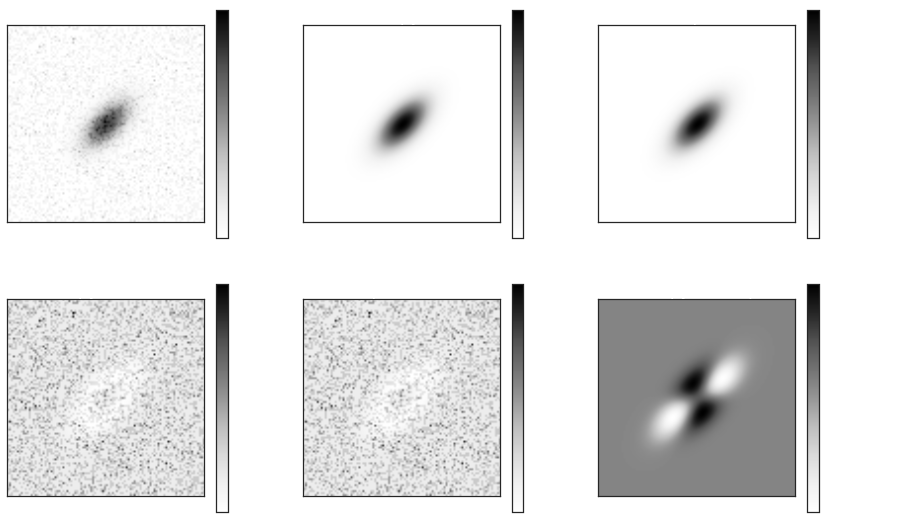

In [3]:
from astropy.io import fits
from astropy.modeling import fitting,models
import sherpa.astro.ui as ui
from photutils.datasets import make_noise_image
from benchmarking import *
import logging
logger = logging.getLogger("sherpa")
logger.setLevel(logging.ERROR)

npix=100
x,y = np.meshgrid(range(npix),range(npix))
data_model = models.Gaussian2D(amplitude=10.,x_mean=npix/2,y_mean=npix/2, \
                        x_stddev = 5.,y_stddev =10., theta = np.pi/4.)
data = data_model(x,y)+make_noise_image((npix,npix), type=u'poisson',mean=.5,stddev=.25)

#ui.load_arrays(1,data)
#this doesn't work so I'm writing to fits for reading by Sherpa

hdu = fits.PrimaryHDU(data)
hdulist = fits.HDUList([hdu])
hdulist.writeto('ap_data.fits',clobber=True)

ui.load_data('ap_data.fits')
ui.set_source(ui.gauss2d.g2)
g2.xpos=npix/2+1
g2.ypos=npix/2+1
g2.ellip = .5
g2.fwhm = sigma2fwhm(10.)
g2.fwhm.min = 1
g2.fwhm.max = 50.
g2.ampl=10.
g2.ampl.min=1
g2.ampl.max=100
g2.theta=3*np.pi/4.
ui.thaw(g2)

ui.set_stat("leastsq")
ui.set_method('levmar')
logger.setLevel(logging.ERROR)
print 'Astropy:'
fit_g = fitting.LevMarLSQFitter()
amod = fit_g(data_model,x,y,data)(x,y)
t1 = %timeit -o -r 3 -n 3 fit_g(data_model,x,y,data)
print '%i iterations' % fit_g.fit_info['nfev']
print '%.2f ms per model evaluation' % (t1.best/fit_g.fit_info['nfev']*1000.)

print '\n'
print 'Sherpa:'
t1 = %timeit -o -r 3 -n 3 ui.fit()
ui.fit()
smod = ui.get_model_image().y
f=ui.get_fit_results()
print '%i iterations' % f.nfev
print '%.2f ms per model evaluation' % (t1.best/f.nfev*1000.)

plt.figure(figsize=(15,9))
titles='Data', 'Astropy Fit','Sherpa Fit','Astropy Residual','Sherpa Residual','Astropy - Sherpa'
for i,im in enumerate([data,amod,smod,data-amod,data-smod,amod-smod]):
    plt.subplot(2,3,i+1)
    plt.imshow(im)
    cbar = plt.colorbar()
    plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='w')
    plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='w')
    plt.xticks([])
    plt.yticks([])
    title=plt.title(titles[i])
    plt.setp(title, color='w')

While Sherpa performs more iterations (likely due to a lower error tolerance threshold), there's no contest. Sherpa wins. So what makes it faster? I'm not sure yet. It's worth finding out but for now I want to implement a very simple improvement to speed up Astropy.

<b><font size="5">Bounding Boxes</font></b>

When you have a large image of the sky containing many discrete sources (stars and galaxies) with lots of space inbetween, it makes little sense to evaluate each source model across the entire image. In the case of our 2D gaussian, 99.9999% of the flux is contained with a 5-sigma radius. 

What I've done is to simply evaluate each source only within these limits. Here I compare Sherpa, Astropy, and Astropy with bb's by timing how long it takes to model 10 sources as a function of image size.

In [7]:
N_sources = 10
width_factor=5
im_sides = np.arange(50,550,50)
t1all,t2all,t3all=[],[],[]
for i in im_sides:
    image = np.zeros((i,i), dtype=np.float64)
    hdu = fits.PrimaryHDU(image)
    hdulist = fits.HDUList([hdu])
    hdulist.writeto('image.fits',clobber=True)
    ui.load_data('image.fits')
    source_table = gen_source_table((i,i),N_sources,stddev=1)
    t=%timeit -r 30 -n 1 -o -q make_gaussian_sources_bb(image, source_table,\
                                                        width_factor=width_factor) 
    t1all.append(t)
    t=%timeit -r 30 -n 1 -o -q make_gaussian_sources(image, source_table)
    t2all.append(t)
    t=%timeit -r 30 -n 1 -o -q make_gaussian_sources_sherpa(image, source_table)
    t3all.append(t)

In [8]:
mt=np.vstack([[0.]*len(im_sides)]*3)
et=np.vstack([[0.]*len(im_sides)]*3)
    
for j,tall in enumerate([t1all,t2all,t3all]):
    for i in range(len(im_sides)):
        mt[j][i]=np.mean(tall[i].all_runs)
        et[j][i]=np.std(tall[i].all_runs)
        
t1,t2,t3 = mt*1000.
e_t1,e_t2,e_t3=et*1000.

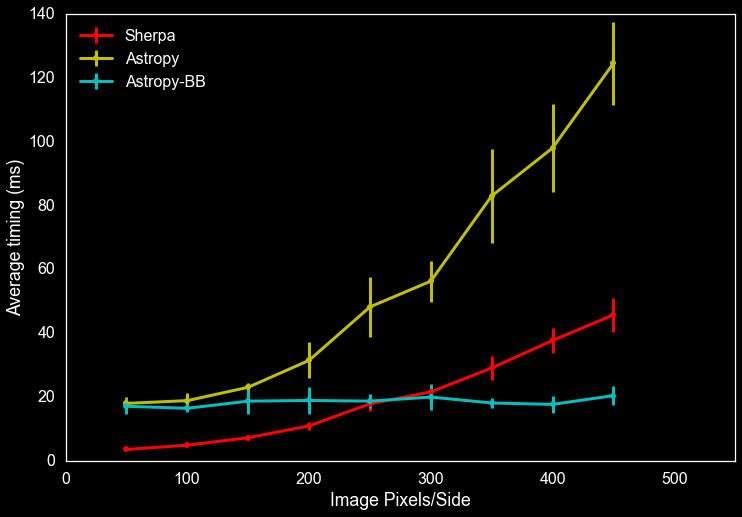

In [11]:
plt.figure(figsize=(12,8))
with plt.style.context((['dark_background'])):
    plt.errorbar(im_sides[:-1],t3[:-1], e_t3[:-1],fmt='r.-',label = 'Sherpa',lw=3,alpha=1)
    plt.errorbar(im_sides[:-1],t2[:-1], e_t2[:-1],fmt='y.-',label = 'Astropy',lw=3,alpha=1)
    plt.errorbar(im_sides[:-1],t1[:-1],e_t1[:-1],fmt='c.-',label = 'Astropy-BB',lw=3,alpha=1)
    plt.legend(frameon=False, loc='left')
    plt.xlabel('Image Pixels/Side')
    plt.ylabel('Average timing (ms)')
    xl=plt.xlim(0,550)

<br>
Sherpa clearly excels over Astropy for any image size up to about 100,000 pixels. At that point, the bounding boxes really start to shine. This limit will of course differ depending on the model used, pixel scale, and source density; but given the same set of sources and pixel scale, the boxes don't change and so the time is independent of the total image size. The more sparsely popuated your image is, the bigger improvement you will see with bounding boxes. 
___